Import all required libraries

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import *
from sklearn.metrics import f1_score,precision_score,recall_score,confusion_matrix,accuracy_score
from sklearn.model_selection import learning_curve,train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve,ShuffleSplit
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.stem import PorterStemmer

Read and initialize train and test dataset (current test dataset is the validation dataset given). You can change the test dataset by changing the testset's path. Note that I personally made a custom folder named "data" where I uploaded the datasets during production

In [ ]:
#dataset and variables initialization
pd.options.mode.chained_assignment = None
fields = ['tweet', 'label']
trainset = pd.read_csv("/content/data/vs_train.csv", usecols=fields)
testset = pd.read_csv("/content/data/vs_dev.csv", usecols=fields)

Let's see how the database is structured

In [ ]:
trainset.head()

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


Here we see some stats about the dataset and we can understand it has 15976 sample tweets and the mean is at 0.93 so the dataset propably has a lot of classes of 0.

In [ ]:
trainset.describe()

,label
count,15976.000000
mean,0.936592
std,0.930740
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


Training and validation datasets Array initialization. We basically split the dataset into tweet and label so we are able to clean it without occuring any problem to the label of each tweet. The last 2 rows are some required datasets of stopwords etc included by the NLTK library which are used after to clean the data.

In [ ]:
X_train = []
Y_train = []
X_train = trainset.tweet
Y_train = trainset.label
X_test = []
Y_test = []
X_test = testset.tweet
Y_test = testset.label

#nltk stopwords and punctuation datasets download
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

This cleaning function works like this:
▶For each row in the sample
▶Split it into tokens
▶if a token is in the stopwords or it is a link continue in the next iteration
▶if it is not then clean it of unecessary symbols and add it back to the sample

In [ ]:
#data cleaning function
def clean_data(dataset):
    stop_words = set(stopwords.words('english'))
    new_dataset = []
    for row in dataset:
      dataset_tokens = word_tokenize(row)
      filtered = ""
      for w in dataset_tokens:
        if (w not in stop_words) and ("http" not in w):
          if ('#' in w) or ('@' in w):
            w.replace('#','')
            w.replace('@','')
            w.replace(',','')
            w.replace('.','')
          filtered = filtered + " " + w
      new_dataset.append(filtered)
    return new_dataset
#Clean the train and test tweet samples
X_train = clean_data(X_train)
X_test = clean_data(X_test)

Count vectorizer (pretty bad scores in the model around 45% - 60%)

In [ ]:
vectorizer = CountVectorizer(max_features=4000)

Hashing Vectorizer. The best vectorizer with score > 65% in most of the tests. Also the best of three with the highest score at 71.3%.

In [ ]:
vectorizer = HashingVectorizer(n_features=3000)

TF-IDF Vectorizer. An also very bad vectorizer that it's scores go around 50% with whichever tweeks I tried.

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)

Tokenization, vectorizing and training


In [ ]:
X_train_vector = vectorizer.fit_transform(X_train)
model = LogisticRegression(max_iter=5000, multi_class='multinomial').fit(X_train_vector,Y_train)

Predictions and score

In [ ]:
#predict and calculate scores
X_test_vector = vectorizer.fit_transform(X_test)
predictions = model.predict(X_test_vector)
f1_micro = f1_score(Y_test, predictions, average='micro')
f1_weighted = f1_score(Y_test, predictions, average='weighted')
acc_score = accuracy_score(Y_test,predictions)
#Print scores
print("f1-micro: ", f1_micro*100,"%")
print("f1-weighted score: ", f1_weighted*100,"%")
print("accuracy score: ", acc_score*100,"%")

f1-micro:  71.38475021910604 %
f1-weighted score:  70.47764624032976 %
accuracy score:  71.38475021910605 %


Print our model's confusion matrix

In [ ]:
print(confusion_matrix(predictions, Y_test))

[[856  65 199]
 [ 23  97  46]
 [186 134 676]]


Plotting the learning curves

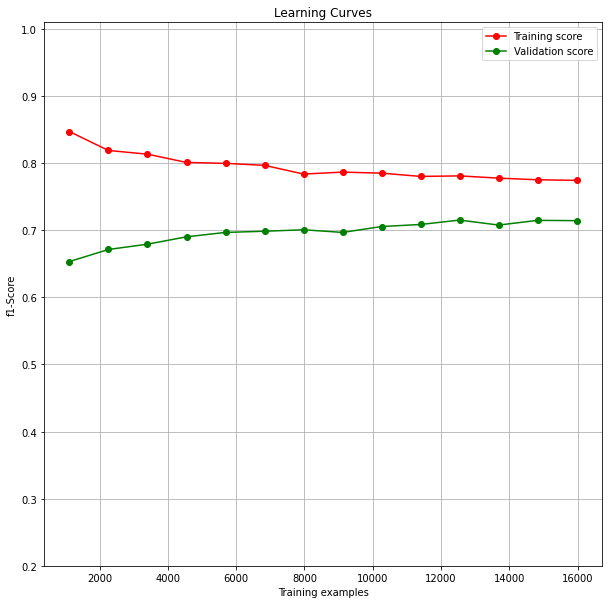

In [ ]:
#This function returns the training score and validation score based on the batch_size given
#For example if the batch size is 0.1 then the train will start from 10% of the dataset and continue at
#20%,30%,... until it reaches 100%
def get_model_scores(estimator,vectorizer,train,test,batch_size=0.1):
    train_scores = []
    test_scores = []
    batch = 0
    X_test = clean_data(test.tweet)
    Xtest_all_vector = vectorizer.fit_transform(X_test)
    Y_test = test.label
    for i in range(int(1/batch_size)):
        batch = batch + batch_size
        if (batch > 1):
          batch = 1
        #Training set splitting with each time by 7% more
        train_batch, test_all = train_test_split(train, test_size=1, train_size=batch)
        #separate X and Y
        X_train_batch = train_batch.tweet
        Y_train_batch = train_batch.label
        #Clean X_train
        X_train_batch = clean_data(X_train_batch)
        #fit predict in the current batch
        Xtrain_batch_vector = vectorizer.fit_transform(X_train_batch)
        model = estimator.fit(Xtrain_batch_vector,Y_train_batch)
        Xtrain_batch_test_vector = vectorizer.fit_transform(X_train_batch)
        predictions = model.predict(Xtrain_batch_test_vector)
        f1 = f1_score(Y_train_batch, predictions, average='micro')
        train_scores.append(f1)
        #Validation fot predict and score on the full validation set
        predictions = model.predict(Xtest_all_vector)
        f1 = f1_score(Y_test, predictions, average='micro')
        test_scores.append(f1)
    return train_scores, test_scores

#plot curves
def plot_learning_curve(estimator, vectorizer,title, tr, tst, batch_size=0.1, axes=None, ylim=None,):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("f1-Score")

    train_sizes=np.linspace(tr.shape[0]*batch_size, tr.shape[0], num=int(1/batch_size))
    train_scores, test_scores = get_model_scores(estimator, vectorizer, tr, tst, batch_size)
    #Uncomment the below code to see exactly the score numbers at each dot of the plot
    #print("TRAIN SCORES: ", train_scores)
    #print("TEST SCORES: ", test_scores)
    axes.grid()
    axes.plot(
        train_sizes, train_scores, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores, "o-", color="g", label="Validation score"
    )
    axes.legend(loc="best")
    return plt


fig, axes = plt.subplots(1, 1, figsize=(10, 10))
estimator=LogisticRegression(max_iter=5000, multi_class='multinomial')
title = "Learning Curves (Naive Bayes)"

plot_learning_curve(
    estimator, vectorizer,"Learning Curves", trainset, testset, 0.07, axes=axes, ylim=(0.2, 1.01)
)

plt.show()

After all the tests i reached in this final code piece which achieves 71.3% accuracy on the test set and almost no overfitting

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
f1-micro:  71.34092900964066 %
f1-weighted score:  70.4319025648829 %
accuracy score:  71.34092900964066 %


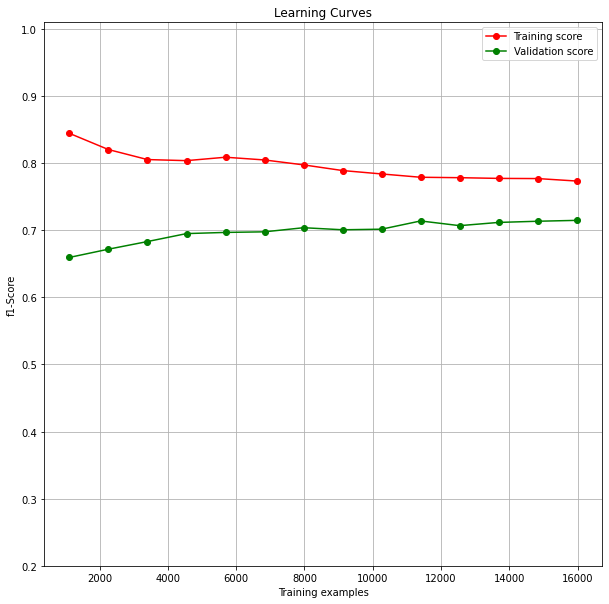

In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import *
from sklearn.metrics import f1_score,precision_score,recall_score,confusion_matrix,accuracy_score
from sklearn.model_selection import learning_curve,train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve,ShuffleSplit
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.stem import PorterStemmer

#dataset and variables initialization
pd.options.mode.chained_assignment = None
fields = ['tweet', 'label']
trainset = pd.read_csv("/content/data/vs_train.csv", usecols=fields)
testset = pd.read_csv("/content/data/vs_dev.csv", usecols=fields)
X_train = []
Y_train = []
X_train = trainset.tweet
Y_train = trainset.label
X_test = []
Y_test = []
X_test = testset.tweet
Y_test = testset.label

#nltk stopwords and punctuation datasets download
nltk.download('stopwords')
nltk.download('punkt')

#data cleaning
def clean_data(dataset):
    stop_words = set(stopwords.words('english'))
    new_dataset = []
    for row in dataset:
      dataset_tokens = word_tokenize(row)
      filtered = ""
      for w in dataset_tokens:
        if (w not in stop_words) and ("http" not in w):
          if ('#' in w) or ('@' in w):
            w.replace('#','')
            w.replace('@','')
            w.replace(',','')
            w.replace('.','')
          filtered = filtered + " " + w
      new_dataset.append(filtered)
    return new_dataset
X_train = clean_data(X_train)
X_test = clean_data(X_test)

#vectorizing and training
vectorizer = HashingVectorizer(strip_accents = 'unicode', n_features=3000)
X_train_vector = vectorizer.fit_transform(X_train)
model = LogisticRegression(max_iter=5000, multi_class='multinomial').fit(X_train_vector,Y_train)

#predict and calculate scores
X_test_vector = vectorizer.fit_transform(X_test)
predictions = model.predict(X_test_vector)
f1_micro = f1_score(Y_test, predictions, average='micro')
f1_weighted = f1_score(Y_test, predictions, average='weighted')
acc_score = accuracy_score(Y_test,predictions)
#Print scores
print("f1-micro: ", f1_micro*100,"%")
print("f1-weighted score: ", f1_weighted*100,"%")
print("accuracy score: ", acc_score*100,"%")

#This function returns the training score and validation score based on the batch_size given
#For example if the batch size is 0.1 then the train will start from 10% of the dataset and continue at
#20%,30%,... until it reaches 100%
def get_model_scores(estimator,vectorizer,train,test,batch_size=0.1):
    train_scores = []
    test_scores = []
    batch = 0
    X_test = clean_data(test.tweet)
    Xtest_all_vector = vectorizer.fit_transform(X_test)
    Y_test = test.label
    for i in range(int(1/batch_size)):
        batch = batch + batch_size
        if (batch > 1):
          batch = 1
        #Training set splitting with each time by 7% more
        train_batch, test_all = train_test_split(train, test_size=1, train_size=batch)
        #separate X and Y
        X_train_batch = train_batch.tweet
        Y_train_batch = train_batch.label
        #Clean X_train
        X_train_batch = clean_data(X_train_batch)
        #fit predict in the current batch
        Xtrain_batch_vector = vectorizer.fit_transform(X_train_batch)
        model = estimator.fit(Xtrain_batch_vector,Y_train_batch)
        Xtrain_batch_test_vector = vectorizer.fit_transform(X_train_batch)
        predictions = model.predict(Xtrain_batch_test_vector)
        f1 = f1_score(Y_train_batch, predictions, average='micro')
        train_scores.append(f1)
        #Validation fot predict and score on the full validation set
        predictions = model.predict(Xtest_all_vector)
        f1 = f1_score(Y_test, predictions, average='micro')
        test_scores.append(f1)
    return train_scores, test_scores

#plot curves
def plot_learning_curve(estimator, vectorizer,title, tr, tst, batch_size=0.1, axes=None, ylim=None,):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("f1-Score")

    train_sizes=np.linspace(tr.shape[0]*batch_size, tr.shape[0], num=int(1/batch_size))
    train_scores, test_scores = get_model_scores(estimator, vectorizer, tr, tst, batch_size)
    #Uncomment the below code to see exactly the score numbers at each dot of the plot
    #print("TRAIN SCORES: ", train_scores)
    #print("TEST SCORES: ", test_scores)
    axes.grid()
    axes.plot(
        train_sizes, train_scores, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores, "o-", color="g", label="Validation score"
    )
    axes.legend(loc="best")
    return plt


fig, axes = plt.subplots(1, 1, figsize=(10, 10))
estimator=LogisticRegression(max_iter=5000, multi_class='multinomial')
title = "Learning Curves (Naive Bayes)"

plot_learning_curve(
    estimator, vectorizer,"Learning Curves", trainset, testset, 0.07, axes=axes, ylim=(0.2, 1.01)
)

plt.show()